# Frozen Lake ⛸️🏞️

![](https://gymnasium.farama.org/_images/frozen_lake.gif)

Este ambiente de treinamento envolve cruzar um lago congelado sem cair nos buracos congelantes. O agente deve aprender a evitar ir sempre na direção desejada por conta do gelo escorregadio.

In [7]:
import gymnasium as gym
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, Image

from lib.QLearning import QLearning
from lib.Sarsa import Sarsa

## Ambientes

In [54]:
env_4x4 = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True).env
env_8x8 = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True).env

## Parâmetros e Hiperparâmetros

In [55]:
n_of_episodes = 30_000
rolling_avg_window = int(n_of_episodes // 10)

Foram escolhidos dois casos para os hyperparametros para treinamento. O `hyperparameters_1` segue uma aprendizagem mais focada na Q-table com pouca aleatorização e menos variação entre episódios. O `hyperparameters_2` tem uma aprendizagem mais aleatorizada porém busca utilizar mais a Q-table conforme os episódios, além de dar mais ênfaze no apendizado entre cada episódio.

In [56]:
hyperparameters_1 = {
    "env": env_4x4,
    "alpha": 0.1,
    "gamma": 0.99,
    "epsilon": 0.1,
    "epsilon_min": 0.1,
    "epsilon_dec": 1,
    "episodes": n_of_episodes,
}

hyperparameters_2 = {
    "env": env_4x4,
    "alpha": 0.25,
    "gamma": 0.99,
    "epsilon": 5.0,
    "epsilon_min": 0.01,
    "epsilon_dec": 0.99,
    "episodes": n_of_episodes,
}

## Treinamento

### Q-Learning

In [57]:
q_learning_qtable_1, q_learning_rewards_1, q_learning_actions_1 = QLearning(**hyperparameters_1).train()
q_learning_qtable_2, q_learning_rewards_2, q_learning_actions_2 = QLearning(**hyperparameters_2).train()

### SARSA

In [58]:
sarsa_qtable_1, sarsa_rewards_1, sarsa_actions_1 = Sarsa(**hyperparameters_1).train()
sarsa_qtable_2, sarsa_rewards_2, sarsa_actions_2 = Sarsa(**hyperparameters_2).train()

### Análise de desempenho

In [59]:
q_learning_rewards_1["Rewards_avg"] = q_learning_rewards_1["Rewards"].rolling(window=rolling_avg_window).mean()
q_learning_rewards_2["Rewards_avg"] = q_learning_rewards_2["Rewards"].rolling(window=rolling_avg_window).mean()

In [60]:
sarsa_rewards_1["Rewards_avg"] = sarsa_rewards_1["Rewards"].rolling(window=rolling_avg_window).mean()
sarsa_rewards_2["Rewards_avg"] = sarsa_rewards_2["Rewards"].rolling(window=rolling_avg_window).mean()

### Plotagem

In [61]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=q_learning_rewards_1["Episodes"],
        y=q_learning_rewards_1["Rewards_avg"],
        name=f'<br>Q-Learning Hiperparâmetros 1<br>α= {hyperparameters_1["alpha"]}, γ= {hyperparameters_1["gamma"]}, ε= {hyperparameters_1["epsilon"]}<br>ε_min= {hyperparameters_1["epsilon_min"]}, ε_dec= {hyperparameters_1["epsilon_dec"]}<br>',
    )
)

fig.add_trace(
    go.Scatter(
        x=sarsa_rewards_1["Episodes"],
        y=sarsa_rewards_1["Rewards_avg"],
        name=f'<br>Sarsa Hiperparâmetros 1<br>α= {hyperparameters_1["alpha"]}, γ= {hyperparameters_1["gamma"]}, ε= {hyperparameters_1["epsilon"]}<br>ε_min= {hyperparameters_1["epsilon_min"]}, ε_dec= {hyperparameters_1["epsilon_dec"]}<br>',
    )
)

fig.add_trace(
    go.Scatter(
        x=q_learning_rewards_2["Episodes"],
        y=q_learning_rewards_2["Rewards_avg"],
        name=f'<br>Q-Learning Hiperparâmetros 2<br>α= {hyperparameters_2["alpha"]}, γ= {hyperparameters_2["gamma"]}, ε= {hyperparameters_2["epsilon"]}<br>ε_min= {hyperparameters_2["epsilon_min"]}, ε_dec= {hyperparameters_2["epsilon_dec"]}<br>',
    )
)

fig.add_trace(
    go.Scatter(
        x=sarsa_rewards_2["Episodes"],
        y=sarsa_rewards_2["Rewards_avg"],
        name=f'<br>Sarsa Hiperparâmetros 2<br>α= {hyperparameters_2["alpha"]}, γ= {hyperparameters_2["gamma"]}, ε= {hyperparameters_2["epsilon"]}<br>ε_min= {hyperparameters_2["epsilon_min"]}, ε_dec= {hyperparameters_2["epsilon_dec"]}<br>',
    )
)

fig.update_layout(
    title="Comparação entre Q-Learning e SARSA com diferentes hiperparâmetros - 30k de episódios",
    xaxis_title="Episodes",
    yaxis_title="Rewards",
    template="presentation",
    showlegend=True,
    width=1_200,
    height=700,
)

fig.show()

In [ ]:
fig.write_image("results/Q-Learning_x_SARSA-hiperparametros.svg")
fig.write_image("results/Q-Learning_x_SARSA-hiperparametros.png")

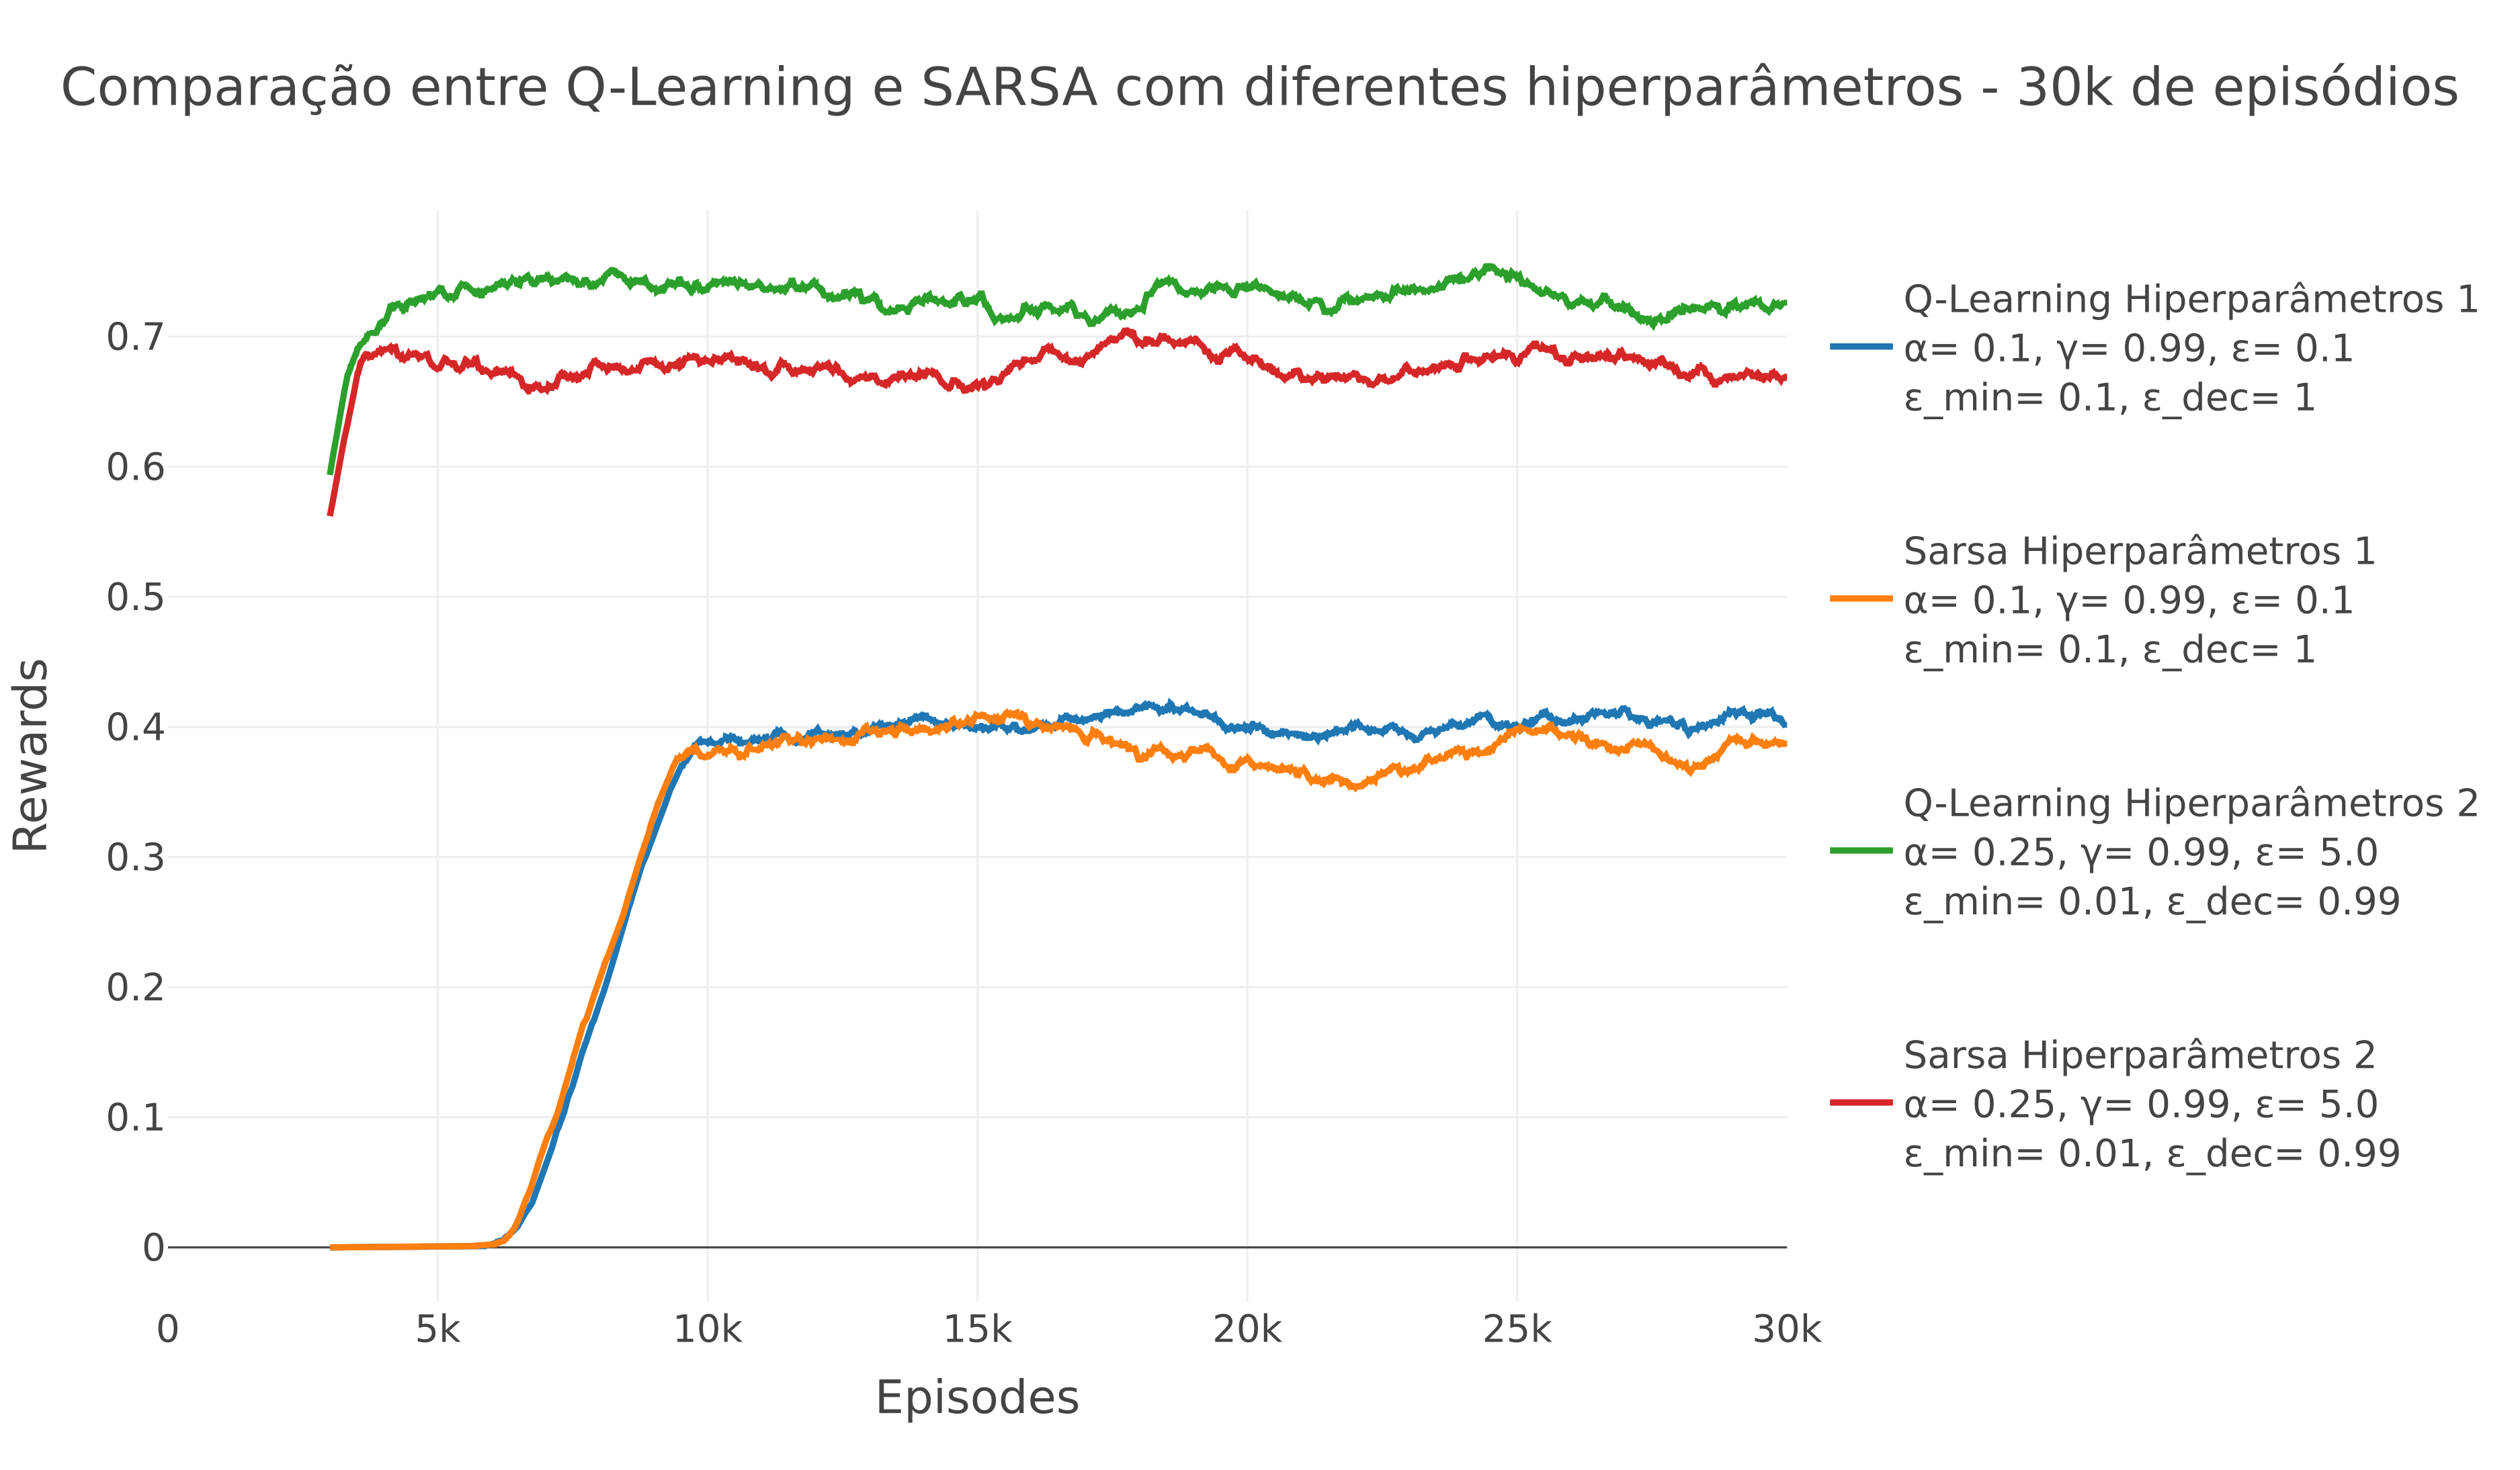

In [10]:
display(Image("results/Q-Learning_x_SARSA-hiperparametros.png"))

### Registro de saída

In [63]:
np.savetxt("results/best_q_learning.csv", q_learning_qtable_2, delimiter=",")
np.savetxt("results/best_sarsa.csv", sarsa_qtable_2, delimiter=",")

## Testes

In [64]:
n_tests = 100
n_tests_2 = 100
hyperparameter_selected = hyperparameters_2

In [65]:
best_q_learning = QLearning(**hyperparameter_selected).load_txt("results/best_q_learning.csv")

tests_q_learning = []

for _ in range(n_tests):
    test_q_learning = pd.Series(
        [
            best_q_learning.test()
            for _ in range(n_tests_2)
        ]
    )

    counts = test_q_learning.value_counts(normalize=True)
    hits = counts[True] * 100

    tests_q_learning.append(hits)

tests_q_learning_describe = pd.Series(tests_q_learning).describe()
tests_q_learning_describe

count    100.00000
mean      82.45000
std        3.81749
min       74.00000
25%       80.00000
50%       82.00000
75%       85.00000
max       92.00000
dtype: float64

In [66]:
best_sarsa = Sarsa(**hyperparameter_selected).load_txt("results/best_sarsa.csv")

tests_sarsa = []

for _ in range(n_tests):
    test_sarsa = pd.Series(
        [
            best_sarsa.test()
            for _ in range(n_tests_2)
        ]
    )

    counts = test_sarsa.value_counts(normalize=True)
    hits = counts[True] * 100

    tests_sarsa.append(hits)

tests_sarsa_describe = pd.Series(tests_sarsa).describe()
tests_sarsa_describe

count    100.000000
mean      78.800000
std        4.199567
min       68.000000
25%       76.000000
50%       79.000000
75%       82.000000
max       88.000000
dtype: float64

In [67]:
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x=tests_q_learning,
        xbins=dict(
            start=0,
            end=100,
            size=1,
        ),
        name="<br>Q-Learning<br>",
    )
)

fig.add_trace(
    go.Histogram(
        x=tests_sarsa,
        xbins=dict(
            start=0,
            end=100,
            size=1,
        ),
        name="<br>Sarsa<br>",
    )
)


fig.add_annotation(x=0.5, y=-0.4, xref='paper', yref='paper', 
                    text=f'<b>Hiperparâmetros:</b> <br>α= {hyperparameter_selected["alpha"]}, γ= {hyperparameter_selected["gamma"]}, ε= {hyperparameter_selected["epsilon"]}<br>ε_min= {hyperparameter_selected["epsilon_min"]}, ε_dec= {hyperparameter_selected["epsilon_dec"]}<br>', 
                    showarrow=False, font=dict(size=18, family="Arial",), align='center')

fig.update_layout(
    title=dict(text=f"Distribuição de acertos em {n_tests} testes",  pad=dict(b=10000)),
    xaxis_title=f"% Acertos em {n_tests_2} episódios",
    yaxis_title="Número de ocorrências",
    template="presentation",
    showlegend=True,
    width=1_200,
    height=700,
    margin=dict(b=200),
)



fig.show()

In [68]:
fig.write_image("results/Q-Learning_x_SARSA-tests.svg")
fig.write_image("results/Q-Learning_x_SARSA-tests.png")

In [11]:
display(Image("results/Q-Learning_x_SARSA-tests.png"))

## Conclusão

Tanto o agente Q-Learning como o Sarsa obtiveram um desempenho semelhante durante o treinamento e mostram resultados significativamente similares. No entanto, na etapa de testes, para 100 testes com 100 episódios cada, o Sara apresentou uma média de acertos por testes superior ao Q_Learning.